<a href="https://colab.research.google.com/github/elmbeech/grn_myeloid_progenitor/blob/main/engr_e542_fall2023_sysbio_network_project_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Boolean transcription factor network for hierarchical differentiation of myeloid progenitor cells**






In [ ]:
%%capture
!apt install libncurses5
!pip install -U tellurium
import os
os.kill(os.getpid(),9)

In [5]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
te.__version__

'2.2.8'

In [171]:
# @title widgets generator
# widget generator
ls_gene = ['CEBPA','CEBPA','FLI1','GATA1','GATA2','GFI1','KLF1 (EKLF)','SPLI1 (PU.1)','TAL1 (SCL)','JUN (cJun)','ZFPM1 (FOG1)']

w_tab = widgets.Tab()
# for each tab
lw_vbox = []
for i_tab, s_tab in enumerate(['None','All','MegE']):
    w_vbox = widgets.VBox()
    # make a checkbox for each gene
    lw_checkbox = []
    for s_gene in ls_gene:
        w_checkbox = widgets.Checkbox(value=False, description='NOP', disabled=False, indent=False)
        w_checkbox.description = s_gene

        # all genes on
        if s_tab in {'All'}:
            w_checkbox.value = True

        # MegE genes on
        elif (s_tab in {'MegE'}) and (s_gene  in {'GATA1','TAL1 (SCL)','ZFPM1 (FOG1)'}):
            w_checkbox.value = True

        lw_checkbox.append(w_checkbox)
    w_vbox.children = lw_checkbox
    lw_vbox.append(w_vbox)
    w_tab.set_title(i_tab, s_tab)
w_tab.children  = lw_vbox


# GATA1 GATA1 ZFPM1 motive
w_radio_gata2gata1zfpm1 = widgets.RadioButtons(
    options=['ALL', 'GATA2','GATA1','ZFPM1 (FOG1)'],
    value='GATA2',
)


# GATA1
w_radio_gata1fli1klf1 = widgets.RadioButtons(
    options=['ALL', 'GATA1','FLI1','KLF1'],
    value='FLI1',
)


## model

Implemented gene inteaction network:
<img src="https://github.com/elmbeech/grn_myeloid_progenitor/blob/main/img/krumsiek2011myeloid_progenitor_graph.png?raw=true" alt="myeloid_progenitor_grn_graph">


In [175]:
# boolen gene regulatory network of myeloid progenitor cells [Krumsiek2011]

s_model = \
"""
Jgata2: -> GATA2; b + GATA2^n / (Km^n + GATA2^n) * (1 - GATA1^n / (Km^n + GATA1^n) * ZFPM1^n / (Km^n + ZFPM1^n)) * (1 - SPI1^n / (Km^n + SPI1^n)) - kd*GATA2;  // GATA2 = GATA2 & !(GATA1 & ZFPM1) & !(SPI1)
Jgata1: -> GATA1; b + ((GATA1^n + GATA2^n + FLI1^n) / (Km^n + GATA1^n + GATA2^n + FLI1^n)) * (1 - SPI1^n / (Km^n + SPI1^n)) - kd*GATA1;  // GATA1 = (GATA1 | GATA2 | FLI1) & !(SPI1)
Jzpfm1: -> ZFPM1; b + GATA1^n / (Km^n + GATA1^n) - kd*ZFPM1;  // FOG1 is ZFPM1 = GATA1
Jklf1: -> KLF1; b + GATA1^n / (Km^n + GATA1^n) * (1 - FLI1^n / (Km^n + FLI1^n)) - kd*KLF1;  // EKLF is KLF1 = GATA1 & !(FLI1)
Jfli1: -> FLI1; b + GATA1^n / (Km^n + GATA1^n) * (1 - KLF1^n / (Km^n + KLF1^n)) - kd*FLI1;  // FLI1 =  GATA1 & !(KLF1)
Jtal1: -> TAL1; b + GATA1^n / (Km^n + GATA1^n) * (1 - SPI1^n / (Km^n + SPI1^n)) - kd*TAL1;  // SCL is TAL1 = GATA1 & !(SPI1)
Jcebpa: -> CEBPA; b + CEBPA^n / (Km^n + CEBPA^n) * (1 - GATA1^n / (Km^n + GATA1^n) * ZFPM1^n / (Km^n + ZFPM1^n) * TAL1^n / (Km^n + TAL1^n)) - kd*CEBPA;  // C/EBPa is CEBPA = CEBPA & !(GATA1 & ZFPM1 & TAL1)
Jspi1: -> SPI1; b + ((CEBPA^n + SPI1^n) / (Km^n + CEBPA^n + SPI1^n)) * (1 - (GATA1^n + GATA2^n) / (Km^n + GATA1^n + GATA2^n)) - kd*SPI1;  //  PU.1 is SPI1 = (CEBPA | SPI1) & !(GATA1 | GATA2);
Jjun: -> JUN; b + SPI1^n / (Km^n + SPI1^n) * (1 - GFI1^n / (Km^n + GFI1^n)) - kd*JUN;  // cJun is JUN = SPI1 & !(GFI1)
Jegrnab: -> EgrNab; b + (SPI1^n / (Km^n + SPI1^n) * JUN^n / (Km^n + JUN^n)) * (1 - GFI1^n / (Km^n + GFI1^n)) - kd*EgrNab;  // {EGR1, EGR2, NAB2} is EgrNab = (SPI1 & JUN) & !(GFI1);
Jgfi1: -> GFI1; b + CEBPA^n / (Km^n + CEBPA^n) * (1 - EgrNab^n / (Km^n + EgrNab^n)) - kd*GFI1;  // GFI1 = CEBPA & !(EgrNab)

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

CEBPA = 0.0;
EgrNab = 0.0;
FLI1 = 0.0;
GATA1 = 0.0;
GATA2 = 0.0;
GFI1 = 0.0;
KLF1 = 0.0;
SPI1 = 0.0;
TAL1 = 0.0;
JUN = 0.0;
ZFPM1 = 0.0;
"""
r = te.loada(s_model)
display(w_tab)

Text(0.5, 0.98, 'myeloid progenitor cell differentiation')

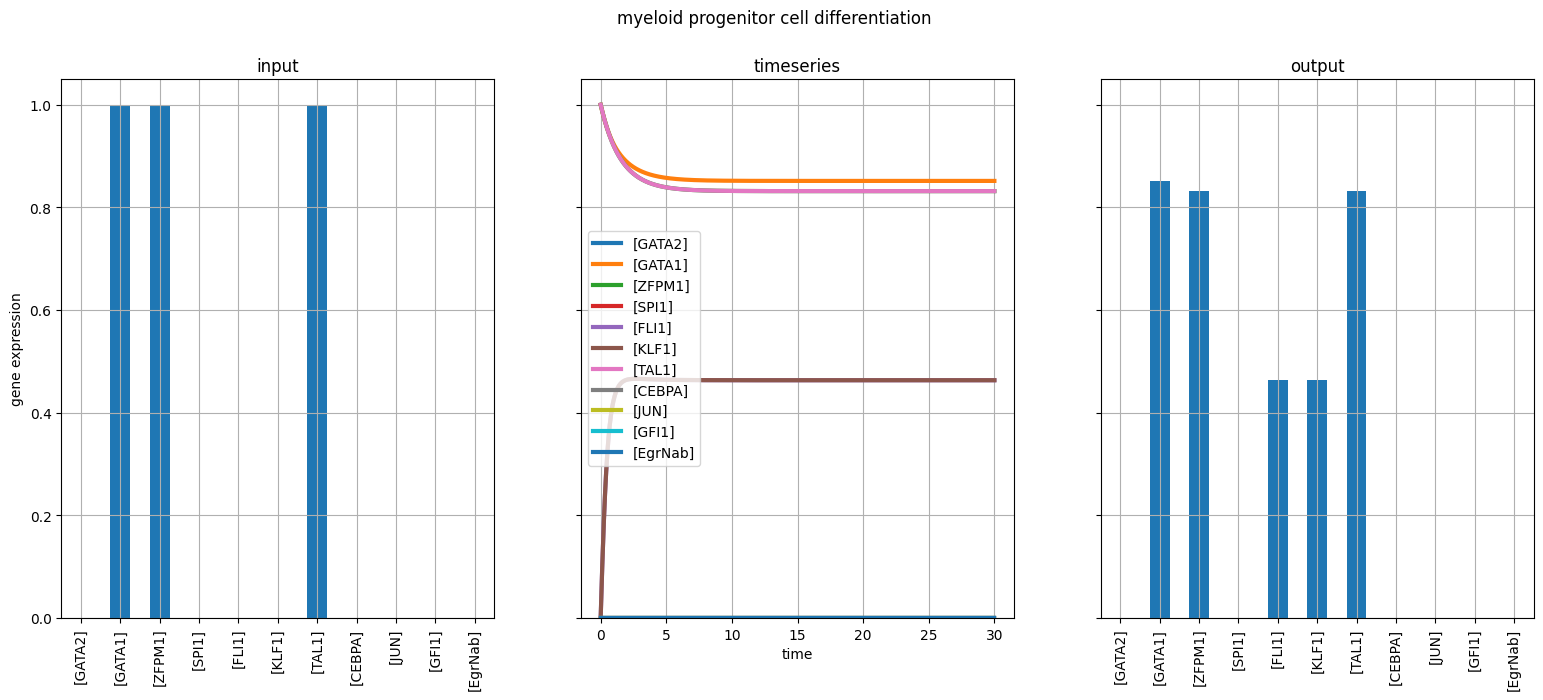

In [178]:
# @title run myeloid progenitor differentiation time series
# run model
r.CEBPA = float(w_tab.children[w_tab.selected_index].children[0].value)
r.EgrNab = float(w_tab.children[w_tab.selected_index].children[1].value)
r.FLI1 = float(w_tab.children[w_tab.selected_index].children[2].value)
r.GATA1 = float(w_tab.children[w_tab.selected_index].children[3].value)
r.GATA2 = float(w_tab.children[w_tab.selected_index].children[4].value)
r.GFI1 = float(w_tab.children[w_tab.selected_index].children[5].value)
r.KLF1 = float(w_tab.children[w_tab.selected_index].children[6].value)
r.SPI1 = float(w_tab.children[w_tab.selected_index].children[7].value)
r.TAL1 = float(w_tab.children[w_tab.selected_index].children[8].value)
r.JUN = float(w_tab.children[w_tab.selected_index].children[9].value)
r.ZFPM1 = float(w_tab.children[w_tab.selected_index].children[10].value)

#m = r.gillespie(0.0, 30.0, 1000)
m = r.simulate(0.0, 30.0, 1000)
df = pd.DataFrame(m,columns=m.colnames)
df.set_index('time', inplace=True)
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(19,7))
df.iloc[0,:].plot(kind='bar', grid=True, ylabel='gene expression', title='input', ax=ax[0])
df.plot(kind='line', linewidth=3, grid=True, ylabel='gene expression', title='timeseries', ax=ax[1])
df.iloc[-1,:].plot(kind='bar', grid=True, ylabel='gene expression', title='output', ax=ax[2])
fig.suptitle('myeloid progenitor cell differentiation')

In [ ]:
df.plot?

## gates

## PROPOSITION gate

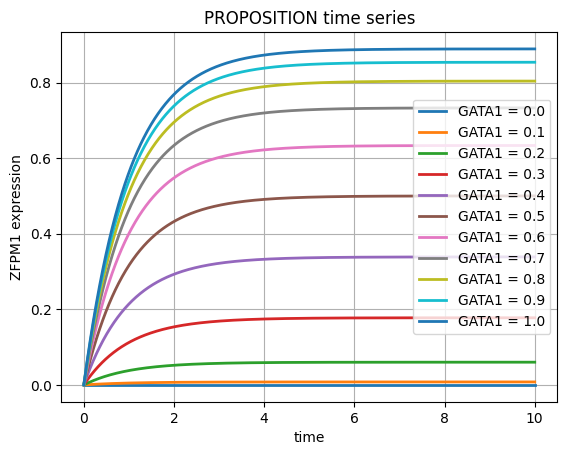

In [180]:
# FOG1 is ZFPM1 = GATA1

s_gate = \
"""
Jzpfm1: -> ZFPM1; b + GATA1^n / (Km^n + GATA1^n) - kd*ZFPM1;  // FOG1 is ZFPM1 = GATA1

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

GATA1 = 0.0;
ZFPM1 = 0.0;
"""

r = te.loada(s_gate)
for GATA1 in np.arange(0.0, 1.1, 0.1):
  r.resetAll()
  r.GATA1 = GATA1
  m = r.simulate(0.0, 10.0, 1000, ['time', 'ZFPM1'])
  te.plotArray(m,
      show=False,
      resetColorCycle =False,
      labels=[f'GATA1 = {round(GATA1,2)}'],
      grid=True,
      ylabel='ZFPM1 expression',
      xlabel='time',
      loc='center right',
      title='PROPOSITION time series',
  )

## NIMPLY gate

<Axes: title={'center': 'NIMPLY gate - input output mapping to KLF*'}, xlabel='GATA1', ylabel='FLI1'>

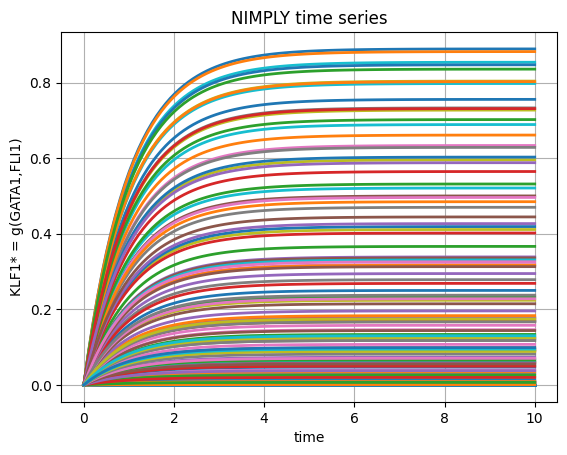

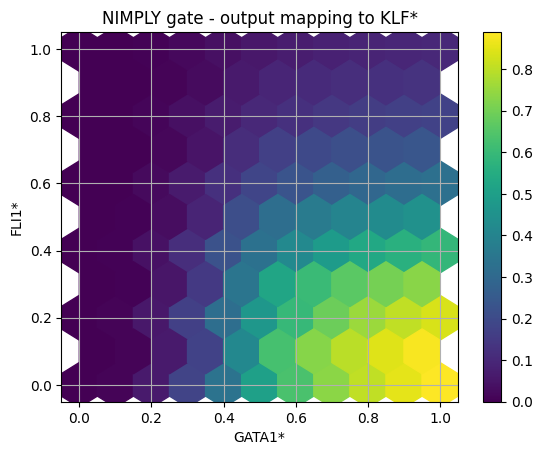

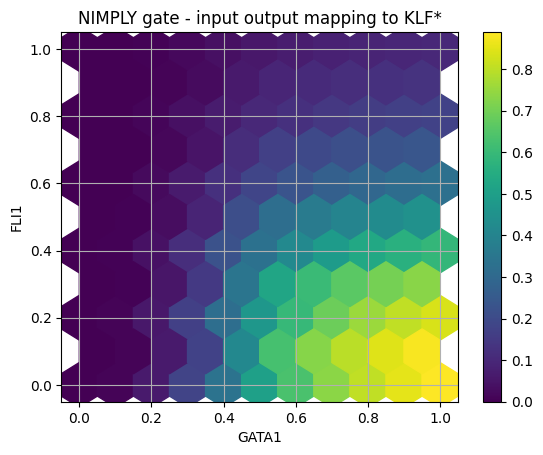

In [181]:
# EKLF is KLF1 = GATA1 & !(FLI1)

s_gate = \
"""
//Jklf1: -> KLF1; b + GATA1^n / (Km^n + GATA1^n) * (Km^n / (Km^n + FLI1^n)) - kd*KLF1;  // EKLF is KLF1 = GATA1 & !(FLI1)
Jklf1: -> KLF1; b + GATA1^n / (Km^n + GATA1^n) * (1 - FLI1^n / (Km^n + FLI1^n)) - kd*KLF1;  // EKLF is KLF1 = GATA1 & !(FLI1)

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

FLI1 = 0.0;
GATA1 = 0.0;
KLF1 = 0.0;
"""

r = te.loada(s_gate)

# processing
a_igate = np.empty(shape=(0,3))
a_ogate = np.empty(shape=(0,3))
for GATA1 in np.arange(0.0, 1.1, 0.1):
    for FLI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1
        r.FLI1 = FLI1
        m = r.simulate(0, 10, 100)
        a_igate = np.vstack([a_igate, [GATA1, FLI1, r.KLF1]])
        a_ogate = np.vstack([a_ogate, [r.GATA1, r.FLI1, r.KLF1]])
        # plot time series
        te.plotArray(m, show = False, resetColorCycle=False,
            grid = True,
            xlabel = 'time',
            ylabel = 'KLF1* = g(GATA1,FLI1)',
            title = 'NIMPLY time series',
        )

# plot gate
df_gate = pd.DataFrame(a_ogate, columns=['GATA1*','FLI1*','KLF1*'])
df_gate.plot(
    kind='hexbin',
    x='GATA1*',
    y='FLI1*',
    C='KLF1*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NIMPLY gate - output mapping to KLF*'
)
df_gate = pd.DataFrame(a_ogate, columns=['GATA1','FLI1','KLF1*'])
df_gate.plot(
    kind='hexbin',
    x='GATA1',
    y='FLI1',
    C='KLF1*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NIMPLY gate - input output mapping to KLF*'
)


NameError: ignored

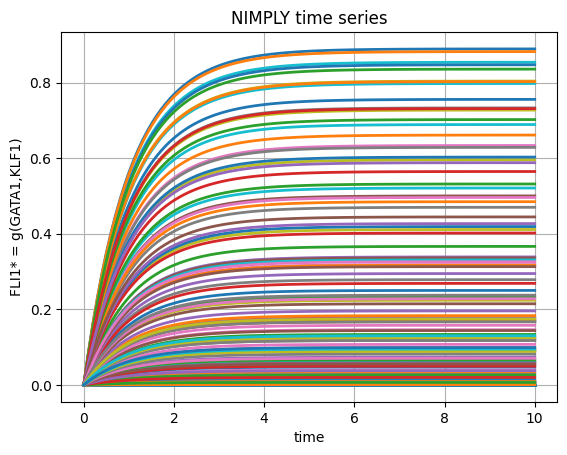

In [179]:
# FLI1 =  GATA1 & !(KLF1)

s_gate = \
"""
Jfli1: -> FLI1; b + GATA1^n / (Km^n + GATA1^n) * (1 - KLF1^n / (Km^n + KLF1^n)) - kd*FLI1;  // FLI1 =  GATA1 & !(KLF1)

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

FLI1 = 0.0;
GATA1 = 0.0;
KLF1 = 0.0;
"""

r = te.loada(s_gate)

# processing
a_gate = np.empty(shape=(0,3))
for GATA1 in np.arange(0.0, 1.1, 0.1):
    for KLF1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1
        r.KLF1 = KLF1
        m = r.simulate(0, 10, 100)
        a_gate = np.vstack([a_gate, [r.GATA1, r.KLF1, r.FLI1]])
        # plot time series
        te.plotArray(m, show = False, resetColorCycle=False,
            grid = True,
            xlabel = 'time',
            ylabel = 'FLI1* = g(GATA1,KLF1)',
            title = 'NIMPLY time series',
        )

# plot gate
df_gate = pd.DataFrame(a_igate, columns=['GATA1*','KLF1*','FLI1*'])
df_gate.plot(
    kind='hexbin',
    x='GATA1*',
    y='KLF1*',
    C='FLI1*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NIMPLY gate - output mapping to FLI1*'
)

In [ ]:
# SCL is TAL1 = GATA1 & !(SPI1)

s_gate = \
"""
Jtal1: -> TAL1; b + GATA1^n / (Km^n + GATA1^n) * (1 - SPI1^n / (Km^n + SPI1^n)) - kd*TAL1;  // SCL is TAL1 = GATA1 & !(SPI1)

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

GATA1 = 0.0;
SPI1 = 0.0;
TAL1 = 0.0;
"""

r = te.loada(s_gate)

# processing
a_gate = np.empty(shape=(0,3))
for GATA1 in np.arange(0.0, 1.1, 0.1):
    for SPI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1
        r.SPI1 = SPI1
        m = r.simulate(0, 10, 100)
        a_gate = np.vstack([a_gate, [r.GATA1, r.SPI1, r.TAL1]])
        # plot time series
        te.plotArray(m, show = False, resetColorCycle=False,
            grid = True,
            xlabel = 'time',
            ylabel = 'TAL1* = g(GATA1,SPI1)',
            title = 'NIMPLY time series',
        )

# plot gate
df_gate = pd.DataFrame(a_gate, columns=['GATA1*','SPI1*','TAL1*'])
df_gate.plot(
    kind='hexbin',
    x='GATA1*',
    y='SPI1*',
    C='TAL1*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NIMPLY gate - output mapping to TAL1*'
)

In [ ]:
# cJun is JUN = SPI1 & !(GFI1)

s_gate = \
"""
Jjun: -> JUN; b + SPI1^n / (Km^n + SPI1^n) * (1 - GFI1^n / (Km^n + GFI1^n)) - kd*JUN;  // cJun is JUN = SPI1 & !(GFI1)

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

GFI1 = 0.0;
JUN = 0.0;
SPI1 = 0.0;
"""

r = te.loada(s_gate)

# processing
a_gate = np.empty(shape=(0,3))
for SPI1 in np.arange(0.0, 1.1, 0.1):
    for GFI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.SPI1 = SPI1
        r.GFI1 = GFI1
        m = r.simulate(0, 10, 100)
        a_gate = np.vstack([a_gate, [r.SPI1, r.GFI1, r.JUN]])
        # plot time series
        te.plotArray(m, show = False, resetColorCycle=False,
            grid = True,
            xlabel = 'time',
            ylabel = 'JUN* = g(SPI1,GFI1)',
            title = 'NIMPLY time series',
        )

# plot gate
df_gate = pd.DataFrame(a_gate, columns=['SPI1*','GFI1*','JUN*'])
df_gate.plot(
    kind='hexbin',
    x='SPI1*',
    y='GFI1*',
    C='JUN*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NIMPLY gate - output mapping to JUN*'
)

In [ ]:
# GFI1 = CEBPA & !(EgrNab)

s_gate = \
"""
Jgfi1: -> GFI1; b + CEBPA^n / (Km^n + CEBPA^n) * (1 - EgrNab^n / (Km^n + EgrNab^n)) - kd*GFI1;  // GFI1 = CEBPA & !(EgrNab)

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

CEBPA = 0.0;
EgrNab = 0.0;
GFI1 = 0.0;
"""

r = te.loada(s_gate)

# processing
a_gate = np.empty(shape=(0,3))
for CEBPA in np.arange(0.0, 1.1, 0.1):
    for EgrNab in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.CEBPA = CEBPA
        r.EgrNab = EgrNab
        m = r.simulate(0, 10, 100)
        a_gate = np.vstack([a_gate, [r.CEBPA, r.EgrNab, r.GFI1]])
        # plot time series
        te.plotArray(m, show = False, resetColorCycle=False,
            grid = True,
            xlabel = 'time',
            ylabel = 'GFI1* = g(CEBPA,EgrNab)',
            title = 'NIMPLY time series',
        )

# plot gate
df_gate = pd.DataFrame(a_gate, columns=['CEBPA*','EgrNab*','GFI1*'])
df_gate.plot(
    kind='hexbin',
    x='CEBPA*',
    y='EgrNab*',
    C='GFI1*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NIMPLY gate - output mapping to GFI1*'
)

In [ ]:
# EgrNab = (SPI1 & JUN) & !(GFI1);

s_gate = \
"""
Jegrnab: -> EgrNab; b + (SPI1^n / (Km^n + SPI1^n) * JUN^n / (Km^n + JUN^n)) * (1 - GFI1^n / (Km^n + GFI1^n)) - kd*EgrNab;  // {EGR1, EGR2, NAB2} is EgrNab = (SPI1 & JUN) & !(GFI1);

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

EgrNab = 0.0;
GFI1 = 0.0;
JUN = 0.0;
SPI1 = 0.0;
"""

r = te.loada(s_gate)

# processing
a_gate = np.empty(shape=(0,3))
for SPI1JUN in np.arange(0.0, 1.1, 0.1):
    for GFI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.SPI1 = SPI1JUN
        r.JUN = SPI1JUN
        r.GFI1 = GFI1
        m = r.simulate(0, 10, 100)
        r_and = min(r.SPI1, r.JUN)  # fuzzy logic
        a_gate = np.vstack([a_gate, [r_and, r.GFI1, r.EgrNab]])
        # plot time series
        te.plotArray(m, show = False, resetColorCycle=False,
            grid = True,
            xlabel = 'time',
            ylabel = 'EgrNab* = g(SPI1,JUN,GFI1)',
            title = 'NIMPLY time series',
        )

# plot gate
df_gate = pd.DataFrame(a_gate, columns=['SPI1&JUN*','GFI1*','EgrNab*'])
df_gate.plot(
    kind='hexbin',
    x='SPI1&JUN*',
    y='GFI1*',
    C='EgrNab*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NIMPLY gate - output mapping to EgrNab* '
)

## NIMPLY gate with autocorrelation

In [ ]:
# GATA1 = (GATA1 | GATA2 | FLI1) & !(SPI1)

s_gate = \
"""
Jgata1: -> GATA1; b + ((GATA1^n + GATA2^n + FLI1^n) / (Km^n + GATA1^n + GATA2^n + FLI1^n)) * (1 - SPI1^n / (Km^n + SPI1^n)) - kd*GATA1;  // GATA1 = (GATA1 | GATA2 | FLI1) & !(SPI1)

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

FLI1 = 0.0;
GATA1 = 0.0;
GATA2 = 0.0;
SPI1 = 0.0;
"""

r = te.loada(s_gate)

# processing
a_igate = np.empty(shape=(0,3))
a_ogate = np.empty(shape=(0,3))
for GATA1GATA2FLI1 in np.arange(0.0, 1.1, 0.1):
    for SPI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1GATA2FLI1
        r.GATA2 = GATA1GATA2FLI1
        r.FLI1 = GATA1GATA2FLI1
        r.SPI1 = SPI1
        m = r.simulate(0, 20, 1000)
        r_or = max(r.GATA1, r.GATA2, r.FLI1)
        a_igate = np.vstack([a_igate, [GATA1GATA2FLI1, SPI1, r.GATA1]])
        a_ogate = np.vstack([a_ogate, [r_or, r.SPI1, r.GATA1]])
        # plot time series
        ax = te.plotArray(m, show = False, resetColorCycle=False,
            grid = True,
            xlabel = 'time',
            ylabel = 'GATA1* = g(GATA1,GATA2,FLI1,SPI1)',
            title = 'NIMPLY time series',
        )
plt.show()

# processing (GATA1 | GATA2 | FLI1) and SPI1
for GATA1GATA2FLI1 in np.arange(0.0, 1.1, 0.1):
    a_bi = np.empty(shape=(0,2))
    for SPI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1GATA2FLI1
        r.SPI1 = SPI1
        m = r.simulate(0, 20, 1000)
        a_bi = np.vstack([a_bi, [SPI1, r.GATA1]])
    # plot bifurcation
    te.plotArray(a_bi, resetColorCycle=False, show=False,
        labels=[f'(GATA1 | GATA2 | FLI1): {round(GATA1GATA2FLI1,2)}'],
        loc = 'upper right',
        grid=True,
        xlabel = 'SPI1',
        ylabel = 'GATA1*',
        title = 'input output mapping',
    )
plt.show()

# processing (GATA1 | GATA2 | FLI1)
for GATA1 in np.arange(0.0, 1.1, 0.1):
    a_bi = np.empty(shape=(0,2))
    for GATA2FLI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r_GATA1GATA2FLI1 = max(GATA1, GATA2FLI1)
        r.GATA1 = GATA1
        r.GATA2 = r_GATA1GATA2FLI1
        r.FLI1 = r_GATA1GATA2FLI1
        m = r.simulate(0, 20, 1000)
        a_bi = np.vstack([a_bi, [r_GATA1GATA2FLI1, r.GATA1]])
    # plot bifurcation
    te.plotArray(a_bi, resetColorCycle=False, show=False,
        labels=[f'GATA1: {round(GATA1,2)}'],
        loc = 'lower right',
        grid=True,
        xlabel = '(GATA1 | GATA2 | FLI1)',
        ylabel = 'GATA1*',
        title = 'input output mapping',
    )
plt.show()

# processing (GATA1 | GATA2 | FLI1) and SPI1
for GATA1GATA2FLI1 in np.arange(0.0, 1.1, 0.1):
    a_bi = np.empty(shape=(0,3))
    for SPI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1GATA2FLI1
        r.GATA2 = GATA1GATA2FLI1
        r.FLI1 = GATA1GATA2FLI1
        r.SPI1 = SPI1
        m = r.simulate(0, 20, 1000)
        r_or = max(r.GATA1, r.GATA2, r.FLI1)
        a_bi = np.vstack([a_bi, [r_or, r.SPI1, r.GATA1]])
    # plot bifurcation
    te.plotArray(a_bi[:,0:2], resetColorCycle=False, show=False,
        labels=[f'(GATA1* | GATA2* | FLI1*): {round(GATA1GATA2FLI1,2)}'],
        loc = 'upper right',
        grid=True,
        xlabel = '(GATA1* | GATA2* | FLI1*)',
        ylabel = 'SPI1*',
        title = 'output mapping',
    )
plt.show()

# plot gate
df_gate = pd.DataFrame(a_ogate, columns=['GATA1*|GATA2*|FLI1*','SPI1*','GATA1*'])
df_gate.plot(
    kind='hexbin',
    x='GATA1*|GATA2*|FLI1*',
    y='SPI1*',
    C='GATA1*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NIMPLY gate - ouput mapping'
)
df_gate = pd.DataFrame(a_igate, columns=['GATA1|GATA2|FLI1','SPI1','GATA1*'])
df_gate.plot(
    kind='hexbin',
    x='GATA1|GATA2|FLI1',
    y='SPI1',
    C='GATA1*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NIMPLY gate - input output mapping'
)


In [ ]:
# PU.1 is SPI1 = (CEBPA | SPI1) & !(GATA1 | GATA2)

s_gate = \
"""
Jspi1: -> SPI1; b + ((CEBPA^n + SPI1^n) / (Km^n + CEBPA^n + SPI1^n)) * (1 - (GATA1^n + GATA2^n) / (Km^n + GATA1^n + GATA2^n)) - kd*SPI1;  //  PU.1 is SPI1 = (CEBPA | SPI1) & !(GATA1 | GATA2);

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

CEBPA = 0.0;
GATA1 = 0.0;
GATA2 = 0.0;
SPI1 = 0.0;
"""

r = te.loada(s_gate)

# processing
a_igate = np.empty(shape=(0,3))
a_ogate = np.empty(shape=(0,3))
for CEBPASPI1 in np.arange(0.0, 1.1, 0.1):
    for GATA1GATA2 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.CEBPA = CEBPASPI1
        r.SPI1 = CEBPASPI1
        r.GATA1 = GATA1GATA2
        r.GATA2 = GATA1GATA2
        m = r.simulate(0, 50, 1000)
        r_or_cebpaspi1 = max(r.CEBPA, r.SPI1)
        r_or_gata1gata2 = max(r.GATA1, r.GATA2)
        a_igate = np.vstack([a_igate, [CEBPASPI1, GATA1GATA2, r.SPI1]])
        a_ogate = np.vstack([a_ogate, [r_or_cebpaspi1, r_or_gata1gata2, r.SPI1]])
        # plot time series
        te.plotArray(m, show = False, resetColorCycle=False,
            grid = True,
            xlabel = 'time',
            ylabel = 'SPI1* = g(CEBPA,SPI1,GATA1,GATA2)',
            title = 'NIMPLY time series',
        )

plt.show()

# processing (CEBPA | SPI1) and (GATA1 | GATA2)
for  CEBPASPI1 in np.arange(0.0, 1.1, 0.1):
    a_bi = np.empty(shape=(0,2))
    for GATA1GATA2 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.CEBPA = CEBPASPI1
        r.SPI1 = CEBPASPI1
        r.GATA1 = GATA1GATA2
        r.GATA2 = GATA1GATA2
        m = r.simulate(0, 50, 100)
        a_bi = np.vstack([a_bi, [GATA1GATA2, r.SPI1]])
    # plot bifurcation
    te.plotArray(a_bi, resetColorCycle=False, show=False,
        labels=[f'(CEBPA | SPI1): {round(CEBPASPI1,2)}'],
        loc = 'upper right',
        grid=True,
        xlabel = '(GATA1 | GATA2)',
        ylabel = 'SPI1*',
        title = 'input output mapping',
    )
plt.show()

# processing CEBPA and SPI1
for SPI1 in np.arange(0.0, 1.1, 0.1):
    a_bi = np.empty(shape=(0,2))
    for CEBPA in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r_CEBPASPI1 = max(SPI1, CEBPA)
        r.CEBPA = r_CEBPASPI1
        r.SPI1 = SPI1
        m = r.simulate(0, 50, 100)
        a_bi = np.vstack([a_bi, [r_CEBPASPI1, r.SPI1]])
    # plot bifurcation
    te.plotArray(a_bi, resetColorCycle=False, show=False,
        labels=[f'SPI1: {round(SPI1,2)}'],
        loc = 'upper right',
        grid=True,
        xlabel = '(CEBPA | SPI1)',
        ylabel = 'SPI1*',
        title = 'input output mapping',
    )
plt.show()

# processing (CEBPA | SPI1) and (GATA1 | GATA2)
for CEBPASPI1 in np.arange(0.0, 1.1, 0.1):
    a_bi = np.empty(shape=(0,3))
    for GATA1GATA2 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.CEBPA = CEBPASPI1
        r.SPI1 = CEBPASPI1
        r.GATA1 = GATA1GATA2
        r.GATA2 = GATA1GATA2
        m = r.simulate(0, 50, 100)
        r_or_cebpaspi1 = max(r.CEBPA, r.SPI1)
        r_or_gata1gata2 = max(r.GATA1, r.GATA2)
        a_bi = np.vstack([a_bi, [r_or_cebpaspi1, r_or_gata1gata2, r.SPI1]])
    # plot bifurcation
    te.plotArray(a_bi[:,0:2], resetColorCycle=False, show=False,
        labels=[f'CEBPA | SPI1: {round(CEBPASPI1,2)}'],
        loc = 'upper right',
        grid=True,
        xlabel = 'CEBPA* | SPI1*',
        ylabel = 'GATA1* | GATA2*',
        title = 'output mapping',
    )
plt.show()


# plot gate
df_gate = pd.DataFrame(a_ogate, columns=['CEBPA*|SPI1*','GATA1*|GATA2*','SPI1*'])
df_gate.plot(
    kind='hexbin',
    x='CEBPA*|SPI1*',
    y='GATA1*|GATA2*',
    C='SPI1*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NIMPLY gate - output mapping to SPI1*'
)
df_gate = pd.DataFrame(a_igate, columns=['CEBPA|SPI1','GATA1|GATA2','SPI1*'])
df_gate.plot(
    kind='hexbin',
    x='CEBPA|SPI1',
    y='GATA1|GATA2',
    C='SPI1*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NIMPLY gate - input output mapping to SPI1*'
)

In [ ]:
# CEBPA = CEBPA & !(GATA1 & ZFPM1 & TAL1)

s_gate = \
"""
Jcebpa: -> CEBPA; b + CEBPA^n / (Km^n + CEBPA^n) * (1 - GATA1^n / (Km^n + GATA1^n) * ZFPM1^n / (Km^n + ZFPM1^n) * TAL1^n / (Km^n + TAL1^n)) - kd*CEBPA;  // C/EBPa is CEBPA = CEBPA & !(GATA1 & ZFPM1 & TAL1)

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

CEBPA = 0.0;
GATA1 = 0.0;
ZFPM1 = 0.0;
TAL1 = 0.0;
"""

r = te.loada(s_gate)

# processing
a_igate = np.empty(shape=(0,3))
a_ogate = np.empty(shape=(0,2))
for CEBPA in np.arange(0.0, 1.1, 0.02):
    for GATA1ZFPM1TAL1 in np.arange(0.0, 1.1, 0.02):
        r.resetToOrigin()
        r.CEBPA = CEBPA
        r.GATA1 = GATA1ZFPM1TAL1
        r.ZFPM1 = GATA1ZFPM1TAL1
        r.TAL1 = GATA1ZFPM1TAL1
        m = r.simulate(0, 60, 1000)
        r_and = min(r.GATA1, r.ZFPM1, r.TAL1)
        a_igate = np.vstack([a_igate, [CEBPA, GATA1ZFPM1TAL1, r.CEBPA]])
        a_ogate = np.vstack([a_ogate, [r.CEBPA, r_and]])
        # plot time series
        te.plotArray(m, show = False, resetColorCycle=False,
            grid = True,
            xlabel = 'time',
            ylabel = 'CEBPA* = g(CEBPA,GATA1,ZFPM1,TAL1)',
            title = 'NIMPLY time series',
        )

# processing CEBPA and (GATA1 & ZFPM1 & TAL1)
for CEBPA in np.arange(0.0, 1.1, 0.1):
    a_bi = np.empty(shape=(0,2))
    for GATA1ZFPM1TAL1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1ZFPM1TAL1
        r.ZFPM1 = GATA1ZFPM1TAL1
        r.TAL1 = GATA1ZFPM1TAL1
        r.CEBPA = CEBPA
        m = r.simulate(0, 50, 100)
        a_bi = np.vstack([a_bi, [GATA1ZFPM1TAL1, r.CEBPA]])
    # plot bifurcation
    te.plotArray(a_bi, resetColorCycle=False, show=False,
        labels=[f'CEBPA: {round(CEBPA,2)}'],
        loc='upper right',
        grid=True,
        xlabel='(GATA1 & ZFPM1 & TAL1)',
        ylabel='CEBPA*',
        title='input output mapping',
    )
plt.show()

# processing CEBPA
a_bi = np.empty(shape=(0,2))
for CEBPA in np.arange(0.0, 1.1, 0.1):
    r.resetToOrigin()
    r.CEBPA = CEBPA
    m = r.simulate(0, 50, 100)
    a_bi = np.vstack([a_bi, [CEBPA, r.CEBPA]])
# plot bifurcation
te.plotArray(a_bi, resetColorCycle=False, show=False,
    labels=[f'CEBPA: {round(CEBPA,2)}'],
    loc='upper left',
    grid=True,
    xlabel='CEBPA',
    ylabel='CEBPA*',
    title='input output mapping',
)
plt.show()

# processing CEBPA and (GATA1 & ZFPM1 & TAL1)
for CEBPA in np.arange(0.0, 1.1, 0.1):
    a_bi = np.empty(shape=(0,2))
    for GATA1ZFPM1TAL1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1ZFPM1TAL1
        r.ZFPM1 = GATA1ZFPM1TAL1
        r.TAL1 = GATA1ZFPM1TAL1
        r.CEBPA = CEBPA
        m = r.simulate(0, 50, 100)
        r_and = min(r.GATA1, r.ZFPM1, r.TAL1)
        a_bi = np.vstack([a_bi, [r.CEBPA, r_and]])
    # plot bifurcation
    te.plotArray(a_bi, resetColorCycle=False, show=False,
        labels=[f'CEBPA: {round(CEBPA,2)}'],
        loc='upper right',
        grid=True,
        xlim=(-0.1,1.1),
        xlabel='CEBPA*',
        ylabel='(GATA1* & ZFPM1* & TAL1*)',
        title='input output mapping',
    )
plt.show()

# plot gate
df_gate = pd.DataFrame(a_ogate, columns=['CEBPA*','GATA1*&ZFPM1*&TAL1*'])
df_gate.plot(
    kind='hexbin',
    x='CEBPA*',
    y='GATA1*&ZFPM1*&TAL1*',
    C='CEBPA*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    xlim=(-0.1,1.2),
    ylim=(-0.1,1.2),
    title='NIMPLY gate - output mapping to CEBPA*'
)
df_gate = pd.DataFrame(a_igate, columns=['CEBPA','GATA1&ZFPM1&TAL1','CEBPA*'])
df_gate.plot(
    kind='hexbin',
    x='CEBPA',
    y='GATA1&ZFPM1&TAL1',
    C='CEBPA*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    xlim=(-0.1,1.2),
    ylim=(-0.1,1.2),
    title = 'NIMPLY gate - input output mapping to CEBPA*'
)

## NAND gate with 3 inputs and autocorrelation

In [ ]:
# GATA2 = GATA2 & !(GATA1 & ZFPM1) & !(SPI1)

s_gate = \
"""
Jgata2: -> GATA2; b + GATA2^n / (Km^n + GATA2^n) * (1 - GATA1^n / (Km^n + GATA1^n) * ZFPM1^n / (Km^n + ZFPM1^n)) * (1 - SPI1^n / (Km^n + SPI1^n)) - kd*GATA2;  // GATA2 = GATA2 & !(GATA1 & ZFPM1) & !(SPI1)

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

ZFPM1 = 0.0;
GATA1 = 0.0;
GATA2 = 0.0;

SPI1 = 0.0;
"""

r = te.loada(s_gate)

# processing
a_igate = np.empty(shape=(0,3))
a_ogate = np.empty(shape=(0,3))
for GATA1ZFPM1 in np.arange(0.0, 1.1, 0.1):
    for SPI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA2 = 1.0;
        r.GATA1 = GATA1ZFPM1
        r.ZFPM1 = GATA1ZFPM1
        r.SPI1 = SPI1
        m = r.simulate(0, 60, 100)
        r_and = min(r.GATA1, r.ZFPM1)
        a_igate = np.vstack([a_igate, [r_and, r.SPI1, r.GATA2]])
        a_ogate = np.vstack([a_ogate, [r_and, r.SPI1, r.GATA2]])
        # plot time series
        te.plotArray(m, show = False, resetColorCycle=False,
            grid = True,
            xlabel = 'time',
            ylabel = 'GATA2* = g(GATA2,GATA1,ZFPM1,SPI1)',
            title = 'NIMPLY time series',
        )
plt.show()

# processing GATA2 and (GATA1 & ZFPM1)
for GATA2 in np.arange(0.0, 1.1, 0.1):
    a_bi = np.empty(shape=(0,2))
    for GATA1ZFPM1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1ZFPM1
        r.ZFPM1 = GATA1ZFPM1
        r.GATA2 = GATA2
        m = r.simulate(0, 50, 100)
        a_bi = np.vstack([a_bi, [GATA1ZFPM1, r.GATA2]])
    # plot bifurcation
    te.plotArray(a_bi, resetColorCycle=False, show=False,
        labels=[f'GATA2: {round(GATA2,2)}'],
        loc='upper right',
        grid=True,
        xlabel='(GATA1 & ZFPM1)',
        ylabel='GATA2*',
        title='input output mapping',
    )
plt.show()

# processing GATA2 and SPI1
for GATA2 in np.arange(0.0, 1.1, 0.1):
    a_bi = np.empty(shape=(0,2))
    for SPI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.SPI1 = SPI1
        r.GATA2 = GATA2
        m = r.simulate(0, 50, 100)
        a_bi = np.vstack([a_bi, [SPI1, r.GATA2]])
    # plot bifurcation
    te.plotArray(a_bi, resetColorCycle=False, show=False,
        labels=[f'GATA2: {round(GATA2,2)}'],
        loc='upper right',
        grid=True,
        xlabel='SPI1',
        ylabel='GATA2*',
        title='input output mapping',
    )
plt.show()

# processing CEBPA
a_bi = np.empty(shape=(0,2))
for GATA2 in np.arange(0.0, 1.1, 0.1):
    r.resetToOrigin()
    r.GATA2 = GATA2
    m = r.simulate(0, 50, 100)
    a_bi = np.vstack([a_bi, [GATA2, r.GATA2]])
# plot bifurcation
te.plotArray(a_bi, resetColorCycle=False, show=False,
    labels=[f'GATA2: {round(GATA2,2)}'],
    loc='upper left',
    grid=True,
    xlabel='GATA2',
    ylabel='GATA2*',
    title='input output mapping',
)
plt.show()

# processing (GATA1 & ZFPM1) and (SPI1)
for GATA1ZFPM1 in np.arange(0.0, 1.1, 0.1):
    a_bi = np.empty(shape=(0,2))
    for SPI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA2 = 1.0
        r.GATA1 = GATA1ZFPM1
        r.ZFPM1 = GATA1ZFPM1
        r.SPI1 = SPI1
        m = r.simulate(0, 50, 100)
        r_and = min(r.GATA1, r.ZFPM1)
        a_bi = np.vstack([a_bi, [r_and, r.SPI1]])
    # plot bifurcation
    te.plotArray(a_bi, resetColorCycle=False, show=False,
        labels=[f'(GATA1 & ZFPM1): {round(GATA1ZFPM1,2)}'],
        loc='upper right',
        grid=True,
        xlabel='(GATA1* & ZFPM1*)',
        ylabel='SPI1*',
        title='input output mapping',
    )
plt.show()

# plot gate
df_gate = pd.DataFrame(a_ogate, columns=['GATA1*&ZFPM1*','SPI1*','GATA2*'])
df_gate.plot(
    kind='hexbin',
    x='GATA1*&ZFPM1*',
    y='SPI1*',
    C='GATA2*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NAND gate - output mapping to GATA2*'
)
df_gate = pd.DataFrame(a_igate, columns=['GATA1&ZFPM1','SPI1','GATA2*'])
df_gate.plot(
    kind='hexbin',
    x='GATA1&ZFPM1',
    y='SPI1',
    C='GATA2*',
    cmap='viridis',
    gridsize=10,
    grid=True,
    title = 'NAND gate - input output mapping to GATA2*'
)

## Flip Flop and Latches Like Motives


### GATA1 GATA2 ZFPM1 motive

In [156]:
# GATA1 GATA2 ZFPM1 motive

s_model = \
"""
Jgata2: -> GATA2; b + GATA2^n / (Km^n + GATA2^n) * (1 - GATA1^n / (Km^n + GATA1^n) * ZFPM1^n / (Km^n + ZFPM1^n)) * (1 - SPI1^n / (Km^n + SPI1^n)) - kd*GATA2;  // GATA2 = GATA2 & !(GATA1 & ZFPM1) & !(SPI1)
Jgata1: -> GATA1; b + ((GATA1^n + GATA2^n + FLI1^n) / (Km^n + GATA1^n + GATA2^n + FLI1^n)) * (1 - SPI1^n / (Km^n + SPI1^n)) - kd*GATA1;  // GATA1 = (GATA1 | GATA2 | FLI1) & !(SPI1)
Jzpfm1: -> ZFPM1; b + GATA1^n / (Km^n + GATA1^n) - kd*ZFPM1;  // FOG1 is ZFPM1 = GATA1

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

FLI1 = 0.0;
GATA1 = 0.0;
GATA2 = 0.0;
SPI1 = 0.0;
ZFPM1 = 0.0;
"""

r = te.loada(s_model)
display(w_radio_gata2gata1zfpm1)


RadioButtons(index=1, options=('ALL', 'GATA2', 'GATA1', 'ZFPM1 (FOG1)'), value='GATA2')

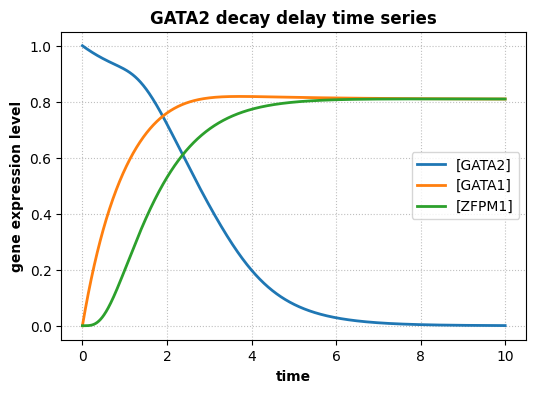

In [157]:
# @title run GATA2 GATA1 ZFPM1 time series
# run model
r.resetToOrigin()
if (w_radio_gata2gata1zfpm1.value in {'ALL','GATA2'}):
    r.GATA2 = 1.0
if (w_radio_gata2gata1zfpm1.value in {'ALL','GATA1'}):
    r.GATA1 = 1.0
if (w_radio_gata2gata1zfpm1.value in {'ALL','ZFPM1 (FOG1)'}):
    r.ZFPM1 = 1.0
r.simulate(0.0, 10.0, 1000)
r.plot(
    grid=True,
    xtitle='time',
    ytitle='gene expression level',
    title='GATA2 decay delay time series',
)

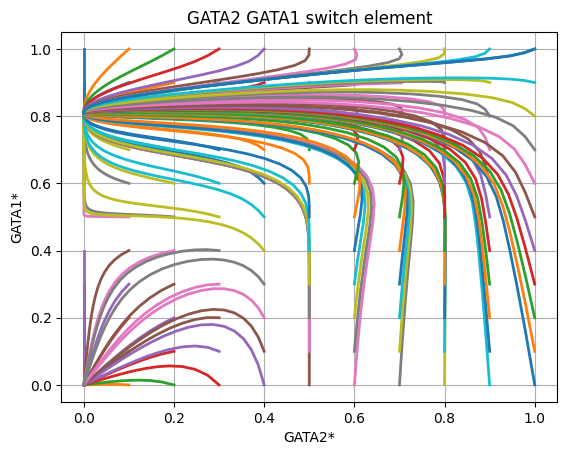

In [160]:
# @title run GATA2 GATA1 phase plot

for GATA2 in np.arange(0.0, 1.1, 0.1):
    for GATA1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA2 = GATA2
        r.GATA1 = GATA1
        m = r.simulate(0,20,100, selections=['[GATA2]','[GATA1]'])
        te.plotArray(m, show=False, resetColorCycle=False)  #
te.plotArray(m,
    show = True,
    grid = True,
    xlabel = 'GATA2*',
    ylabel = 'GATA1*',
    title = 'GATA2 GATA1 switch element',
)

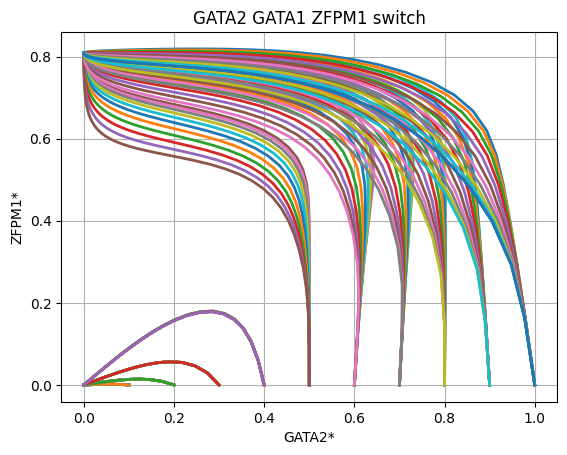

In [161]:
# @title run GATA1 ZFPM1 phaseplot

for GATA2 in np.arange(0.0, 1.1, 0.1):
    for ZFPM1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA2 = GATA2
        r.ZFPM1 = ZFPM1
        m = r.simulate(0,20,100, selections=['[GATA2]','[GATA1]'])
        te.plotArray(m, show=False, resetColorCycle=False)  #
te.plotArray(m,
    show = True,
    grid = True,
    xlabel = 'GATA2*',
    ylabel = 'ZFPM1*',
    title = 'GATA2 GATA1 ZFPM1 switch',
)

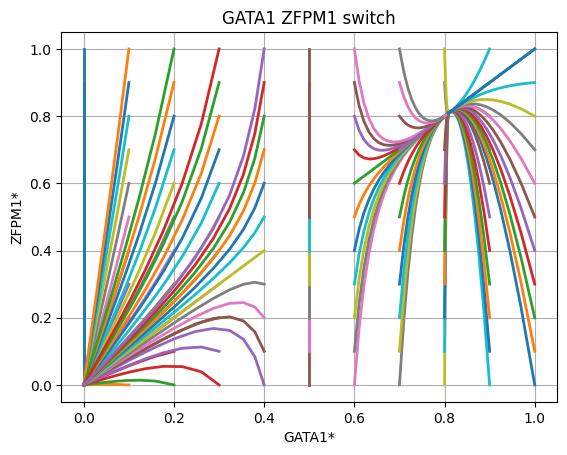

In [162]:
# @title GATA1 ZFPM1 phase plot

for GATA1 in np.arange(0.0, 1.1, 0.1):
    for ZFPM1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1
        r.ZFPM1 = ZFPM1
        m = r.simulate(0,30,100, selections=['[GATA1]','[ZFPM1]'])
        te.plotArray(m, show=False, resetColorCycle=False)  #
te.plotArray(m,
    show = True,
    grid = True,
    xlabel = 'GATA1*',
    ylabel = 'ZFPM1*',
    title = 'GATA1 ZFPM1 switch',
)

### GATA1 FLI1 KLF1 motive

In [164]:
s_model = \
"""
Jgata1: -> GATA1; b + ((GATA1^n + GATA2^n + FLI1^n) / (Km^n + GATA1^n + GATA2^n + FLI1^n)) * (1 - SPI1^n / (Km^n + SPI1^n)) - kd*GATA1;  // GATA1 = (GATA1 | GATA2 | FLI1) & !(SPI1)
Jfli1: -> FLI1; b + GATA1^n / (Km^n + GATA1^n) * (1 - KLF1^n / (Km^n + KLF1^n)) - kd*FLI1;  // FLI1 =  GATA1 & !(KLF1)
Jklf1: -> KLF1; b + GATA1^n / (Km^n + GATA1^n) * (1 - FLI1^n / (Km^n + FLI1^n)) - kd*KLF1;  // EKLF is KLF1 = GATA1 & !(FLI1)

b = 0.0;
n = 3.0;
//vmax = 1.0;
Km = 0.5;
kd = 1.0;

//CEBPA = 0.0;
//EgrNab = 0.0;
FLI1 = 0.0;
GATA1 = 0.0;
GATA2 = 0.0;
GFI1 = 0.0;
KLF1 = 0.0;
SPI1 = 0.0;
TAL1 = 0.0;
//JUN = 0.0;
ZFPM1 = 0.0;
"""
r = te.loada(s_model)
display(w_radio_gata1fli1klf1)

RadioButtons(index=1, options=('ALL', 'GATA1', 'FLI1', 'KLF1'), value='GATA1')

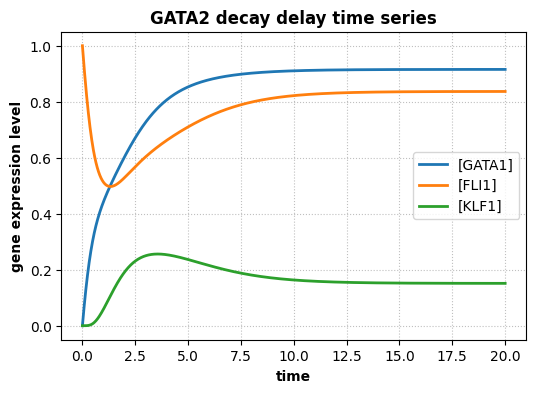

In [170]:
# @title run GATA1 KLF1 FLI1 time series
# run model
r.resetToOrigin()
if (w_radio_gata1fli1klf1.value in {'ALL','GATA1'}):
    r.GATA1 = 1.0
if (w_radio_gata1fli1klf1.value in {'ALL','FLI1'}):
    r.FLI1 = 1.0
if (w_radio_gata1fli1klf1.value in {'ALL','KLF1'}):
    r.KLF1 = 1.0
r.simulate(0.0, 20.0, 1000)
r.plot(
    grid=True,
    xtitle='time',
    ytitle='gene expression level',
    title='GATA2 decay delay time series',
)

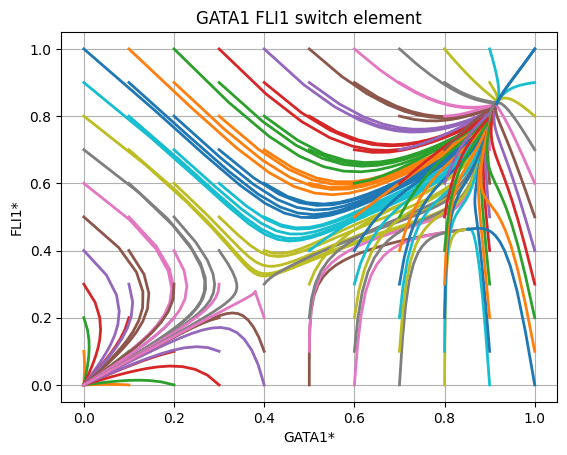

In [172]:
# @title run GATA1 FLI1 phase plot

for GATA1 in np.arange(0.0, 1.1, 0.1):
    for FLI1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1
        r.FLI1 = FLI1
        m = r.simulate(0,20,100, selections=['[GATA1]','[FLI1]'])
        te.plotArray(m, show=False, resetColorCycle=False)  #
te.plotArray(m,
    show = True,
    grid = True,
    xlabel = 'GATA1*',
    ylabel = 'FLI1*',
    title = 'GATA1 FLI1 switch element',
)

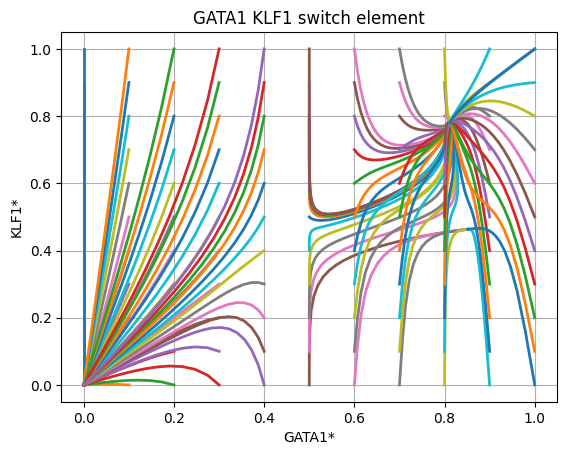

In [173]:
# @title run GATA1 KLF1 phase plot

for GATA1 in np.arange(0.0, 1.1, 0.1):
    for KLF1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.GATA1 = GATA1
        r.KLF1 = KLF1
        m = r.simulate(0,20,100, selections=['[GATA1]','[KLF1]'])
        te.plotArray(m, show=False, resetColorCycle=False)  #
te.plotArray(m,
    show = True,
    grid = True,
    xlabel = 'GATA1*',
    ylabel = 'KLF1*',
    title = 'GATA1 KLF1 switch element',
)

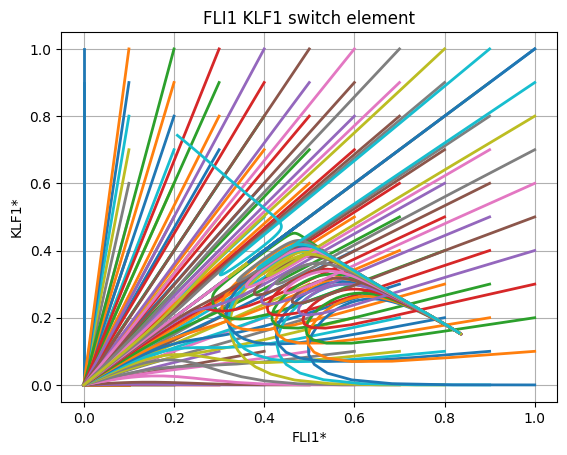

In [174]:
# @title run FLI1 KLF1 phase plot

for FLI1 in np.arange(0.0, 1.1, 0.1):
    for KLF1 in np.arange(0.0, 1.1, 0.1):
        r.resetToOrigin()
        r.FLI1 = FLI1
        r.KLF1 = KLF1
        m = r.simulate(0,20,100, selections=['[FLI1]','[KLF1]'])
        te.plotArray(m, show=False, resetColorCycle=False)  #
te.plotArray(m,
    show = True,
    grid = True,
    xlabel = 'FLI1*',
    ylabel = 'KLF1*',
    title = 'FLI1 KLF1 switch element',
)

## GATA2 GATA1 SPI1 TAL1 motive

## GF1 JUN EgrNab motive

## CEBPA TAL1 GFI1 JUN EgrNab motive

# References

+ [Krumsiek2010] *Krumsiek, Jan and Pölsterl, Sebastian and Wittmann, Dominik M and Theis, Fabian J*, **Odefy - From discrete to continuous models**, *BMC Bioinformatics*, *2010-05*, https://doi.org/10.1186/1471-2105-11-233

+ [Krumsiek2011] *Krumsiek, Jan and Marr, Carsten and Schroeder, Timm and Theis, Fabian J.*, **Hierarchical Differentiation of Myeloid Progenitors Is Encoded in the Transcription Factor Network**, *PLoS ONE*, *2011-08*, https://doi.org/10.1371/journal.pone.0022649

+ [Wittmann2009] *Wittmann, Dominik M and Krumsiek, Jan and Saez-Rodriguez, Julio and Lauffenburger, Douglas A and Klamt, Steffen and Theis, Fabian J*,
 **Transforming Boolean models to continuous models: methodology and application to T-cell receptor signaling**, *BMC Systems Biology*, *2009-09*, https://doi.org/10.1186/1752-0509-3-98

+ [Wolf2018] *Wolf, F. Alexander and Angerer, Philipp and Theis, Fabian J.*, **SCANPY: large-scale single-cell gene expression data analysis**, *Genome Biology*, *2018-02*, https://doi.org/10.1186/s13059-017-1382-0

